In [64]:
from pathlib import Path
from typing import Dict, Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:


def plot_active_learning_comparison_mpl(
    name_to_results_dir: Dict[str, Path],
    y_col: str = 'elpp',
    x_col: str = 'round',
    y_label: str = 'ELPP',
    x_label: str = 'Active learning iteration',
    figsize: Tuple[int, int] = (6, 4),
    dpi: int = 200,
    palette: Optional[List[str]] = None,
    ax: Optional[plt.Axes] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Loads active learning results and creates a comparison plot using only Matplotlib.

    For each method, it shows a boxplot of the results at each iteration and
    a line connecting the mean values across iterations.

    Args:
        name_to_results_dir: A dictionary mapping method names to the Path
                             of their results directory.
        y_col: The name of the column in the CSV to use for the y-axis.
        x_col: The name of the column in the CSV to use for the x-axis.
        y_label: The label for the y-axis.
        x_label: The label for the x-axis.
        figsize: The size of the figure to create.
        dpi: The resolution of the figure.
        palette: A list of color strings. If None, default 'C0', 'C1', ... used.
        ax: An existing matplotlib Axes object to plot on. If None, a new
            figure and axes are created.

    Returns:
        A tuple containing the matplotlib Figure and Axes objects.
    """
    # --- 1. Load and combine data into a single DataFrame ---
    all_dfs = []
    # Use the keys from the input dict to preserve order
    method_names = list(name_to_results_dir.keys())

    for name in method_names:
        results_dir = name_to_results_dir[name]
        df_path = results_dir / 'results.csv'
        if df_path.exists():
            df = pd.read_csv(df_path, header=0)
            df['method'] = name
            all_dfs.append(df)
        else:
            print(f"Warning: Could not find 'results.csv' in {results_dir}")

    if not all_dfs:
        raise ValueError("No data could be loaded. Please check paths.")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    # Ensure 'method' is a categorical type with the specified order
    combined_df['method'] = pd.Categorical(combined_df['method'], categories=method_names, ordered=True)


    # --- 2. Set up the plot and data structures ---
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = ax.get_figure()

    rounds = sorted(combined_df[x_col].unique())
    n_methods = len(method_names)

    if palette is None:
        # Use Matplotlib's default color cycle
        palette = [f'C{i}' for i in range(n_methods)]

    # --- 3. Manually calculate positions for grouped boxplots ---
    # The x-axis ticks will be at 0, 1, 2, ... for each round
    x_indices = np.arange(len(rounds))

    # Define the total width for a group of boxes at one round
    total_width = 0.4
    # Width of a single boxplot
    single_width = total_width / n_methods

    # --- 4. Plot Boxplots and Mean Lines for each method ---
    for i, method in enumerate(method_names):
        # Calculate the center position for this method's boxes at each round
        # Start from the left of the group center, then shift by the method's index
        positions = x_indices - (total_width / 2) + (i + 0.5) * single_width

        # Collect data for this method at each round
        data_to_plot = [
            combined_df[(combined_df['method'] == method) & (combined_df[x_col] == r)][y_col].values
            for r in rounds
        ]

        # Plot the boxplots for the current method
        bp = ax.boxplot(
            data_to_plot,
            positions=positions,
            widths=single_width,
            patch_artist=True,  # Important for filling with color
            showfliers=False,   # Hide outliers as requested
            medianprops={'color': 'black', 'linewidth': 1.5}
        )

        # Set the color for the boxes
        color = palette[i]
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.6) # Add some transparency

        # Plot the line connecting the means
        mean_values = [np.median(d) for d in data_to_plot]
        ax.plot(positions, mean_values, color=color, marker='o', linestyle='-', label=method)

    # --- 5. Customize the plot ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Set the x-ticks to be in the center of each group of boxes
    ax.set_xticks(x_indices)
    ax.set_xticklabels(rounds)

    ax.legend(title='Method')
    fig.tight_layout()

    return fig, ax


(-0.38, -0.28)

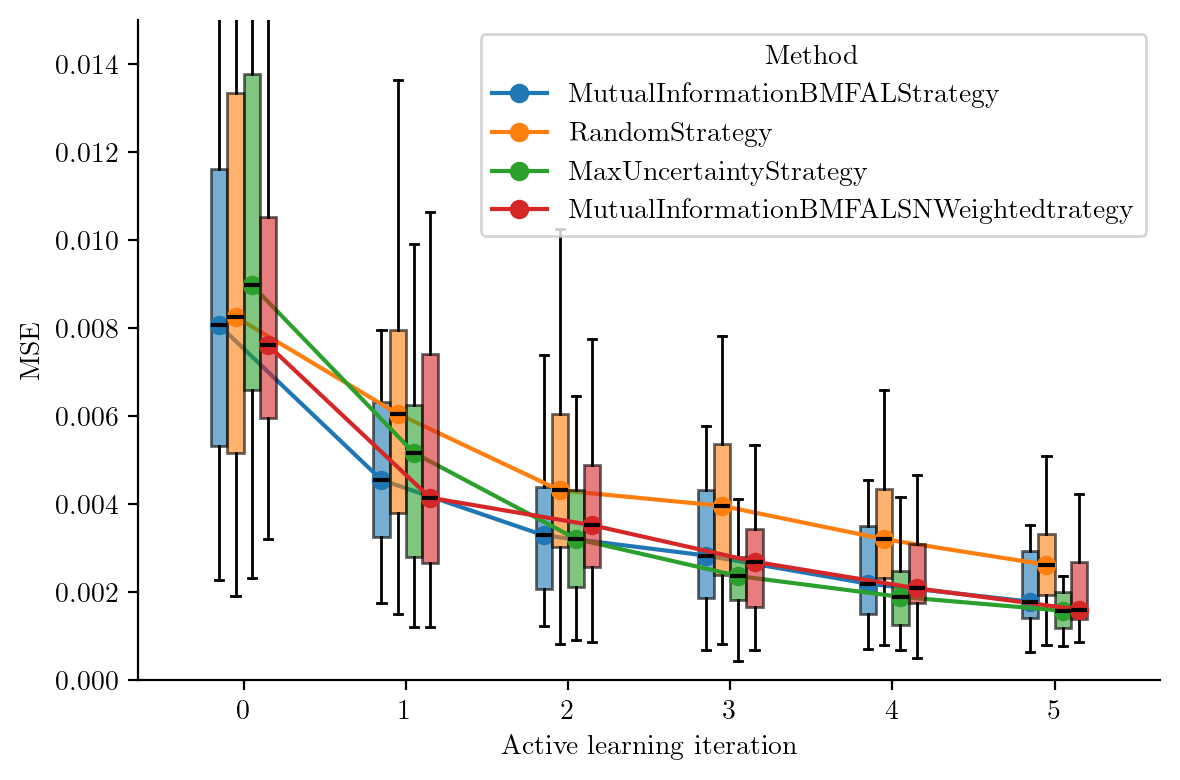

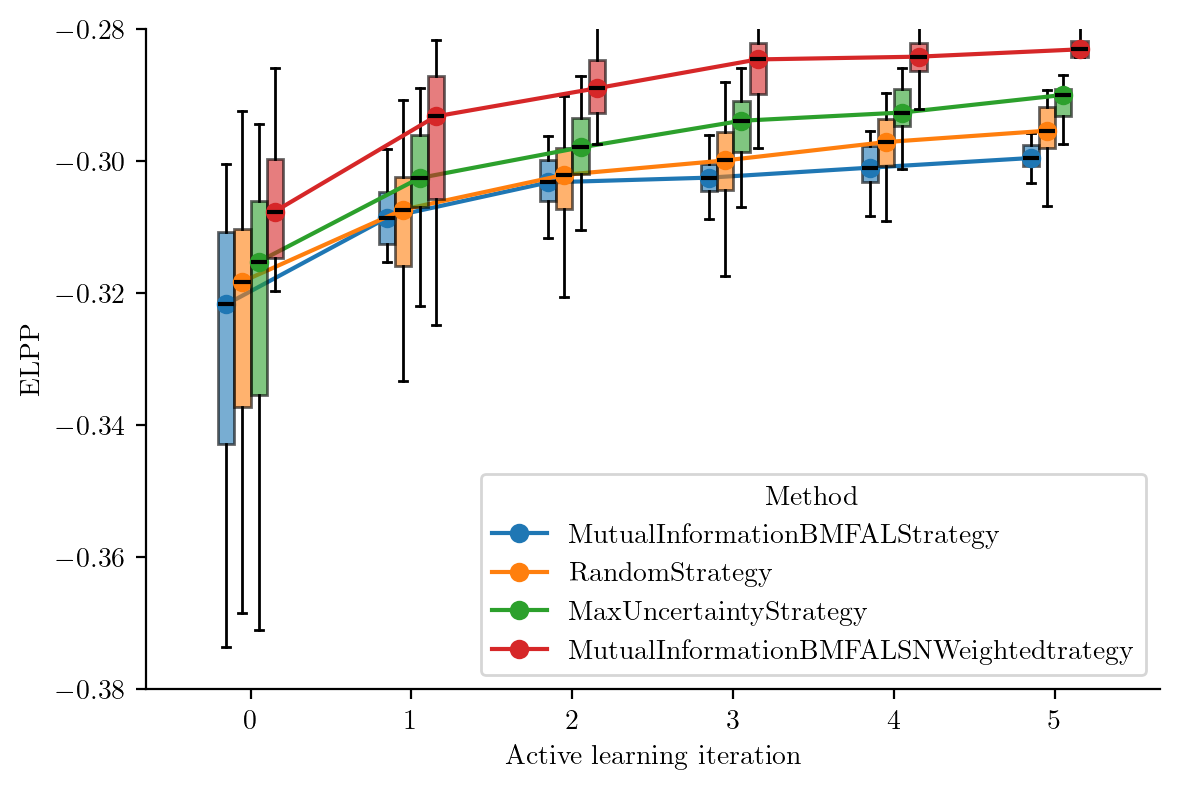

In [90]:
# Linear problem, 20 reps of each method

results_to_plot = Path('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/comparison4')
results_to_plot = list(results_to_plot.glob('2025*'))

name_to_results_dir = {
    x.name.split("_")[2].split("(")[0]: x for x in results_to_plot
}

fig, ax = plot_active_learning_comparison_mpl(name_to_results_dir, y_col='mse', x_col='round', y_label='MSE', x_label='Active learning iteration',)
ax.set_ylim(0, 0.015)
fig, ax = plot_active_learning_comparison_mpl(name_to_results_dir, y_col='elpp', x_col='round', y_label='ELPP', x_label='Active learning iteration',)
ax.set_ylim(-0.38,-0.28)

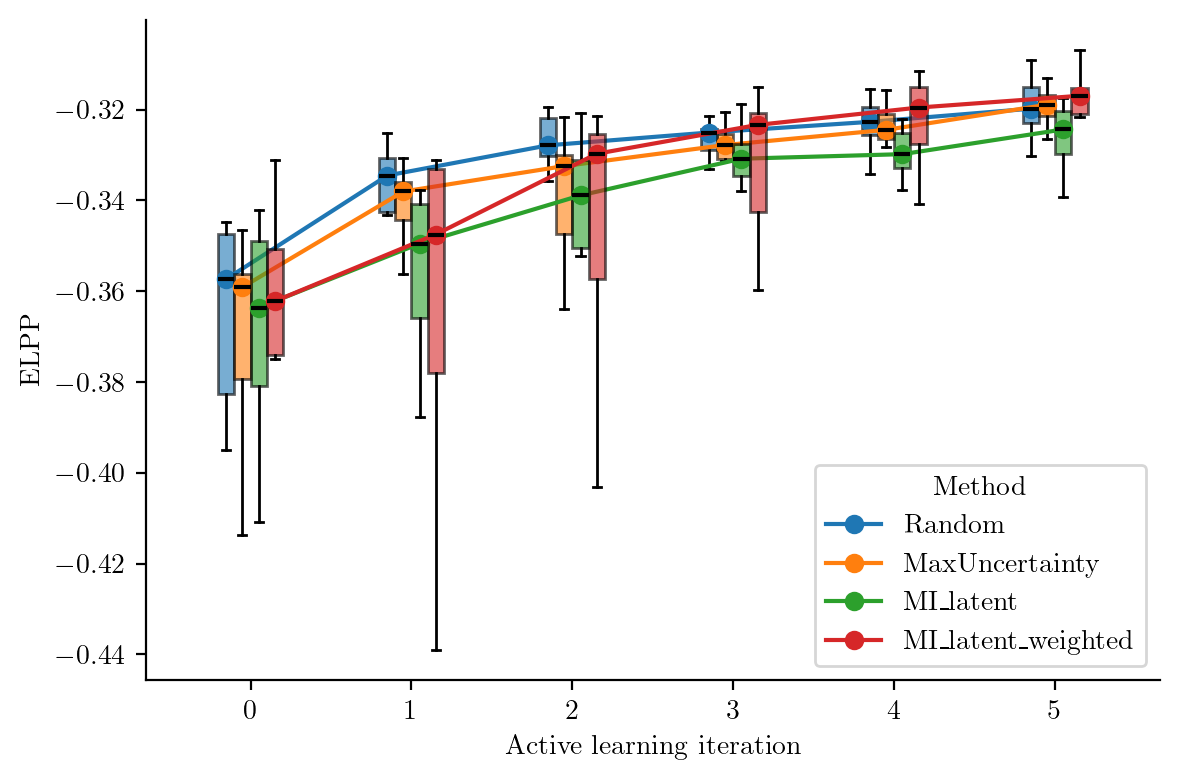

In [76]:
results_to_plot = Path('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyNonlinear/comparison')
results_to_plot = list(results_to_plot.glob('2025*'))

names = [
    'Random',
    'MaxUncertainty',
    'MI_latent',
    'MI_latent_weighted'
]

name_to_results_dir = {
    n: x for n, x in zip(names, results_to_plot)
}

fig, ax = plot_active_learning_comparison_mpl(name_to_results_dir, y_col='elpp', x_col='round', y_label='ELPP', x_label='Active learning iteration',)


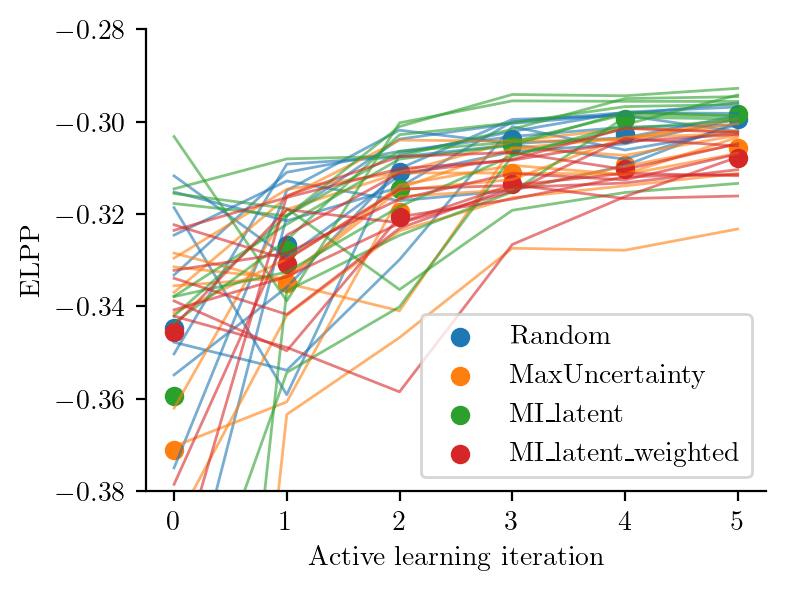

In [60]:
results_to_plot = Path('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/comparison')
results_to_plot = list(results_to_plot.glob('*'))

names = [
    'Random',
    'MaxUncertainty',
    'MI_latent',
    'MI_latent_weighted'
]

name_to_results_dir = {
    n: x for n, x in zip(names, results_to_plot)
}

name_to_df = {}
for name, results_dir in name_to_results_dir.items():
    df_path = Path(results_dir) / 'results.csv'
    df = pd.read_csv(df_path, header=0)
    name_to_df[name] = df

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

i = 0
for name, df in name_to_df.items():
    rounds = df['round'].unique()

    xs = list(sorted(rounds))
    ys_mean = np.array([df[df['round'] == i]['elpp'].mean() for i in xs])
    ax.scatter(xs, ys_mean, marker='o', label=name, color=f'C{i}')

    # plot each individual line for this method with alpha=0.3
    seed_col = 'repeat'
    all_seeds = df[seed_col].unique()
    for seed in all_seeds:
        df_run = df[df[seed_col] == seed]
        ys_run = [df_run[df_run['round'] == r]['elpp'].mean() for r in xs]
        ax.plot(xs, ys_run, color=f'C{i}', alpha=0.6, linewidth=1)

    #yerrs = np.array([df[df['round'] == i]['elpp'].std() for i in xs])
    #ax.fill_between(xs, ys - yerrs, ys + yerrs, alpha=0.3)
    i += 1

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Active learning iteration')
ax.set_xticks(xs)
ax.set_ylabel('ELPP')

ax.set_ylim(-0.38, -0.28)

ax.legend()

plt.show()




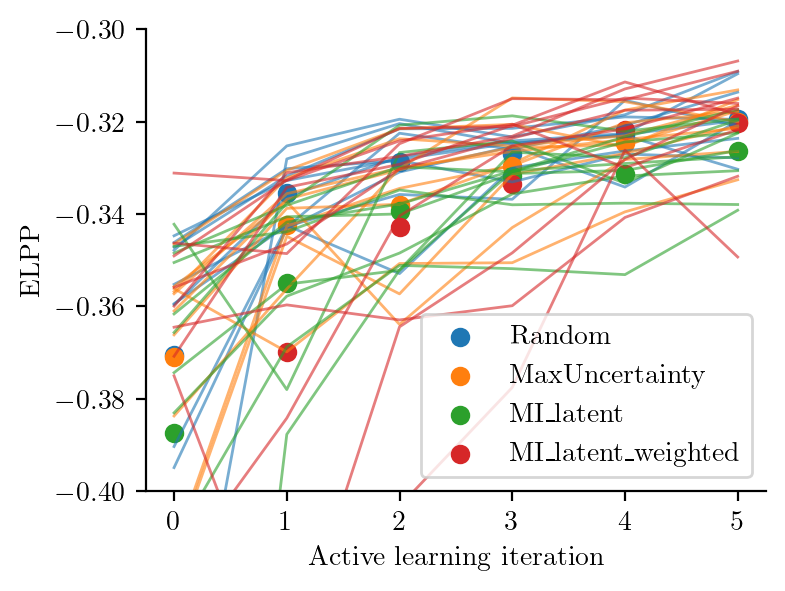

In [62]:

results_to_plot = Path('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyNonlinear/comparison')
results_to_plot = list(results_to_plot.glob('*'))

names = [
    'Random',
    'MaxUncertainty',
    'MI_latent',
    'MI_latent_weighted'
]

name_to_results_dir = {
    n: x for n, x in zip(names, results_to_plot)
}

name_to_df = {}
for name, results_dir in name_to_results_dir.items():
    df_path = Path(results_dir) / 'results.csv'
    df = pd.read_csv(df_path, header=0)
    name_to_df[name] = df

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

i = 0
for name, df in name_to_df.items():
    rounds = df['round'].unique()

    xs = list(sorted(rounds))
    ys_mean = np.array([df[df['round'] == i]['elpp'].mean() for i in xs])
    ax.scatter(xs, ys_mean, marker='o', label=name, color=f'C{i}')

    # plot each individual line for this method with alpha=0.3
    seed_col = 'repeat'
    all_seeds = df[seed_col].unique()
    for seed in all_seeds:
        df_run = df[df[seed_col] == seed]
        ys_run = [df_run[df_run['round'] == r]['elpp'].mean() for r in xs]
        ax.plot(xs, ys_run, color=f'C{i}', alpha=0.6, linewidth=1)

    #yerrs = np.array([df[df['round'] == i]['elpp'].std() for i in xs])
    #ax.fill_between(xs, ys - yerrs, ys + yerrs, alpha=0.3)
    i += 1

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Active learning iteration')
ax.set_xticks(xs)
ax.set_ylabel('ELPP')

ax.set_ylim(-0.40, -0.30)

ax.legend()

plt.show()



In [35]:
name_to_results_dir = {
    #'Random': '/Users/murray/Projects/MultiFidelityActiveLearning/output/20250624_122621_ToyLinear_RandomStrategy',
    #'MaxUncertainty($\\beta=0$)': '/Users/murray/Projects/MultiFidelityActiveLearning/output/20250624_141708_ToyLinear_MUDStrategy(beta=0.0, gamma=0.5)'
    'Random': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/20250630_174256_ToyLinear_RandomStrategy(gamma=0.5000)',
    'MaxUncertainty': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/20250630_174519_ToyLinear_MaxUncertaintyStrategy(beta=0.5, gamma=0.5)',
    'BMFAL_latents': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/20250702_122806_ToyLinear_MutualInformationBMFALStrategy',
    'MICE_latents': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/20250702_132034_ToyLinear_MutualInformationGridStrategy'
}

In [36]:
name_to_df = {}
for name, results_dir in name_to_results_dir.items():
    df_path = Path(results_dir) / 'results.csv'
    df = pd.read_csv(df_path, header=0)
    name_to_df[name] = df

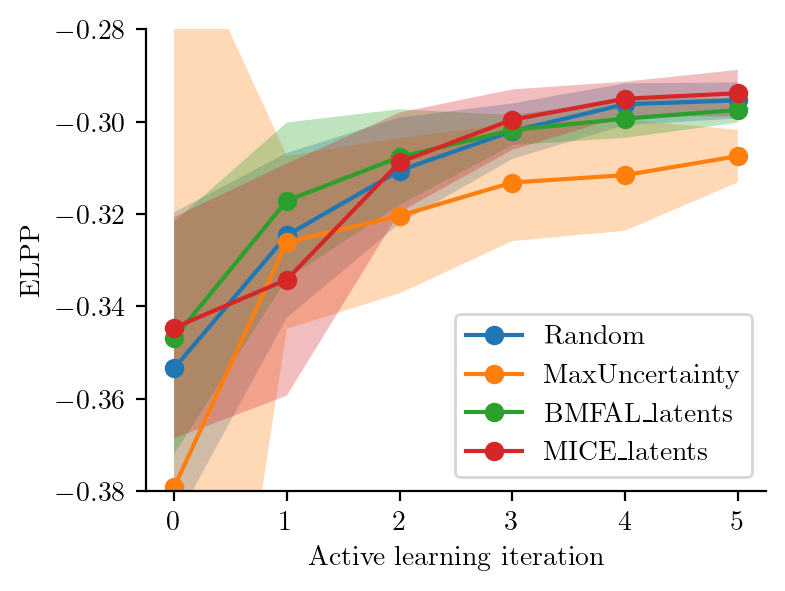

In [37]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

for name, df in name_to_df.items():
    rounds = df['round'].unique()

    xs = list(sorted(rounds))
    ys = np.array([df[df['round'] == i]['elpp'].mean() for i in xs])
    yerrs = np.array([df[df['round'] == i]['elpp'].std() for i in xs])

    ax.plot(xs, ys, marker='o', label=name)
    ax.fill_between(xs, ys - yerrs, ys + yerrs, alpha=0.3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Active learning iteration')
ax.set_xticks(xs)
ax.set_ylabel('ELPP')

ax.set_ylim(-0.38, -0.28)

ax.legend()

plt.show()

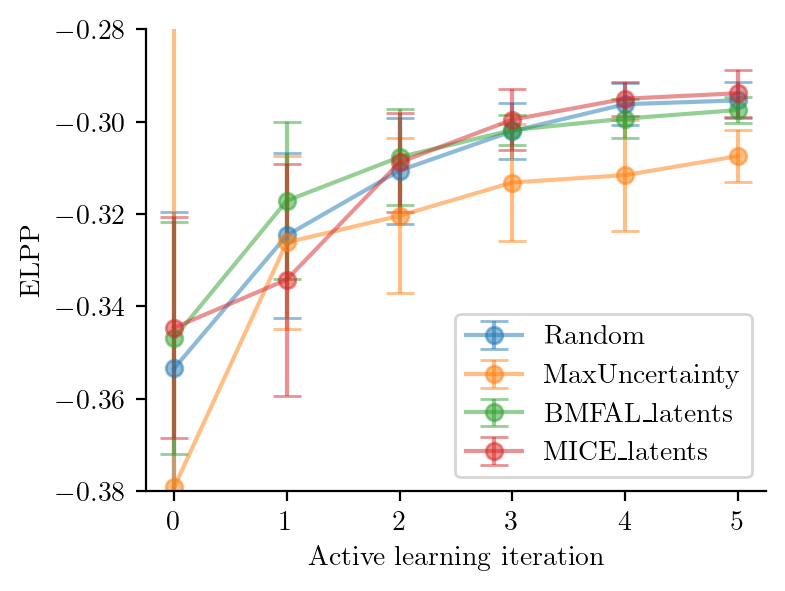

In [40]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

for name, df in name_to_df.items():
    rounds = df['round'].unique()

    xs = list(sorted(rounds))
    ys = np.array([df[df['round'] == i]['elpp'].mean() for i in xs])
    yerrs = np.array([df[df['round'] == i]['elpp'].std() for i in xs])

    ax.errorbar(xs, ys, yerr=yerrs, marker='o', label=name, capsize=5, alpha=0.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Active learning iteration')
ax.set_xticks(xs)
ax.set_ylabel('ELPP')

ax.set_ylim(-0.38, -0.28)

ax.legend()

plt.show()


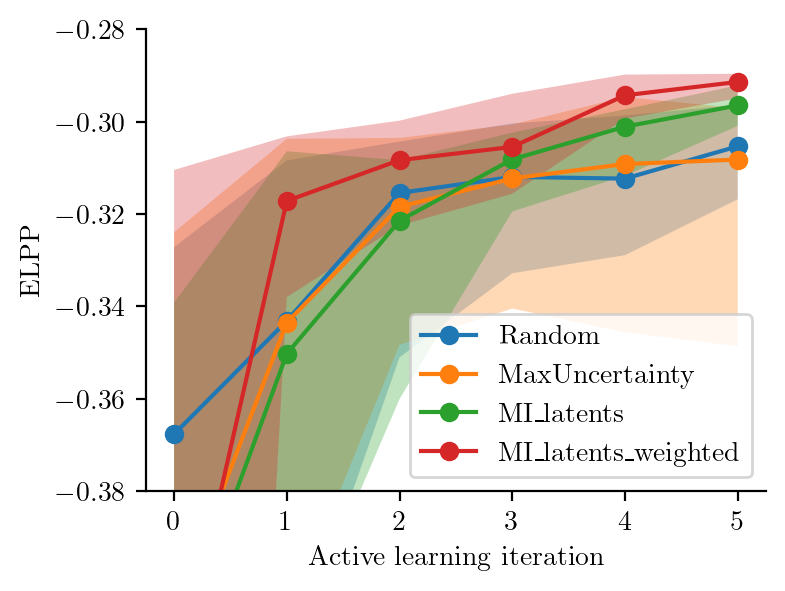

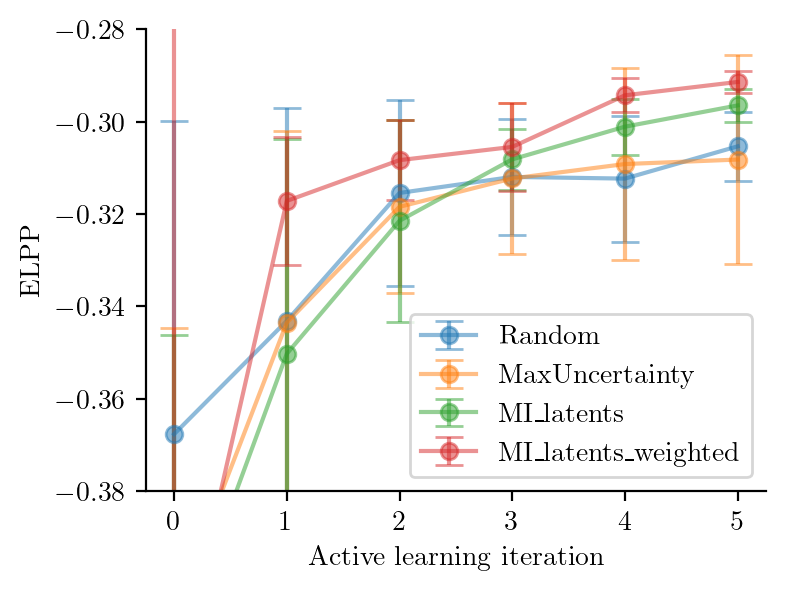

In [50]:
# Now with 256 inducing points


name_to_results_dir = {
    'Random': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/20250703_203211_ToyLinear_RandomStrategy(gamma=0.5000)',
    'MaxUncertainty': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/20250703_203440_ToyLinear_MaxUncertaintyStrategy(beta=0.5, gamma=0.5)',
    'MI_latents': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/20250703_203721_ToyLinear_MutualInformationBMFALStrategy',
    'MI_latents_weighted': '/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/20250703_231143_MutualInformationBMFALSNWeightedtrategy(maxN=10,jitter=0.002,sigma_reduction_prop=0.9)'
}
name_to_df = {}
for name, results_dir in name_to_results_dir.items():
    df_path = Path(results_dir) / 'results.csv'
    df = pd.read_csv(df_path, header=0)
    name_to_df[name] = df
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

for name, df in name_to_df.items():
    rounds = df['round'].unique()

    xs = list(sorted(rounds))
    ys = np.array([df[df['round'] == i]['elpp'].mean() for i in xs])
    yerrs = np.array([df[df['round'] == i]['elpp'].std() for i in xs])
    y_mins = np.array([df[df['round'] == i]['elpp'].min() for i in xs])
    y_maxs = np.array([df[df['round'] == i]['elpp'].max() for i in xs])

    ax.plot(xs, ys, marker='o', label=name)
    ax.fill_between(xs, y_mins, y_maxs, alpha=0.3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Active learning iteration')
ax.set_xticks(xs)
ax.set_ylabel('ELPP')

ax.set_ylim(-0.38, -0.28)

ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

for name, df in name_to_df.items():
    rounds = df['round'].unique()

    xs = list(sorted(rounds))
    ys = np.array([df[df['round'] == i]['elpp'].mean() for i in xs])
    yerrs = np.array([df[df['round'] == i]['elpp'].std() for i in xs])

    ax.errorbar(xs, ys, yerr=yerrs, marker='o', label=name, capsize=5, alpha=0.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Active learning iteration')
ax.set_xticks(xs)
ax.set_ylabel('ELPP')

ax.set_ylim(-0.38, -0.28)

ax.legend()

plt.show()


[PosixPath('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/20250703_231143_MutualInformationBMFALSNWeightedtrategy(maxN=10,jitter=0.002,sigma_reduction_prop=0.9)'), PosixPath('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/20250704_001301_MutualInformationBMFALSNWeightedtrategy(maxN=5,jitter=0.002,sigma_reduction_prop=0.95)'), PosixPath('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/20250703_224328_MutualInformationBMFALSNWeightedtrategy(maxN=20,jitter=0.002,sigma_reduction_prop=0.8)'), PosixPath('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/20250704_025355_MutualInformationBMFALSNWeightedtrategy(maxN=10,jitter=0.001,sigma_reduction_prop=0.95)'), PosixPath('/Users/murray/Projects/MultiFidelityActiveLearning/output/active_learning/ToyLinear/20250704_041337_MutualInformationBMFALSNWeightedtrategy(maxN=10,jitter=0.004,sigma_reduction_prop=0

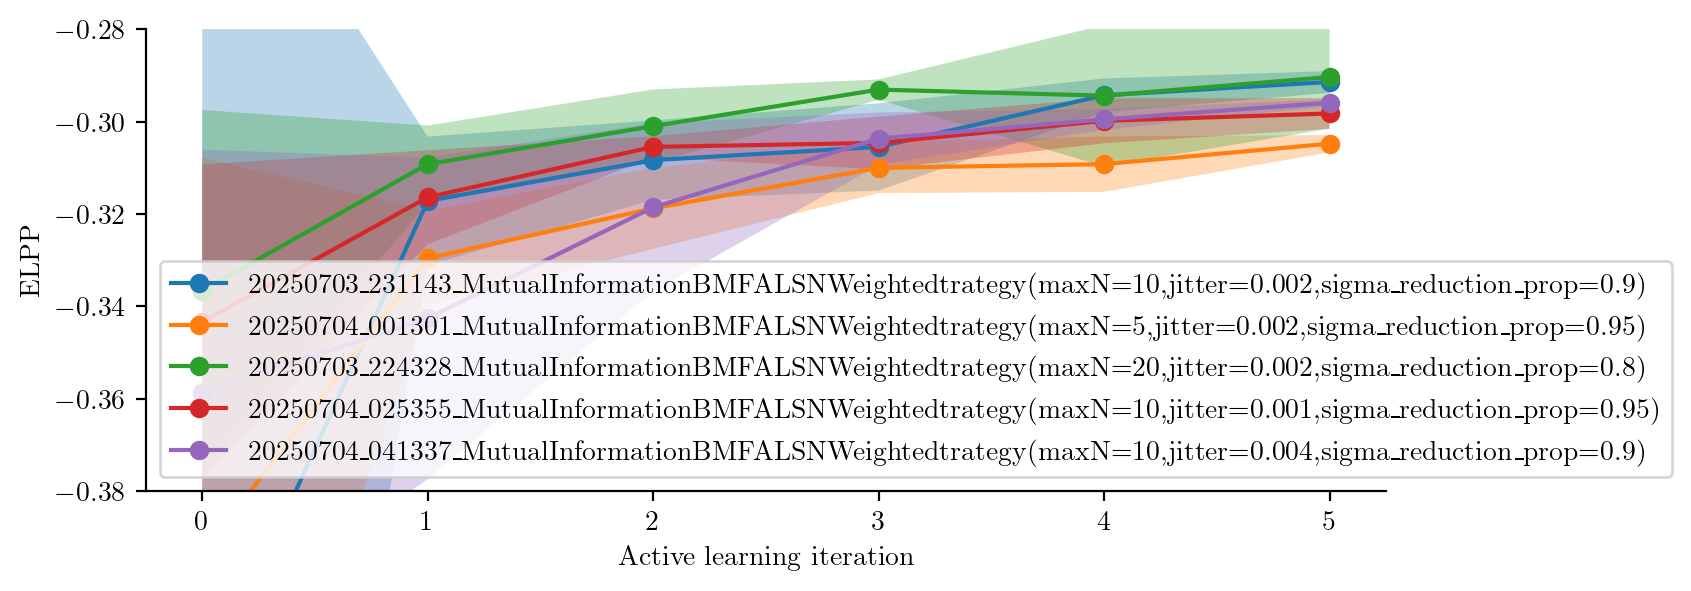

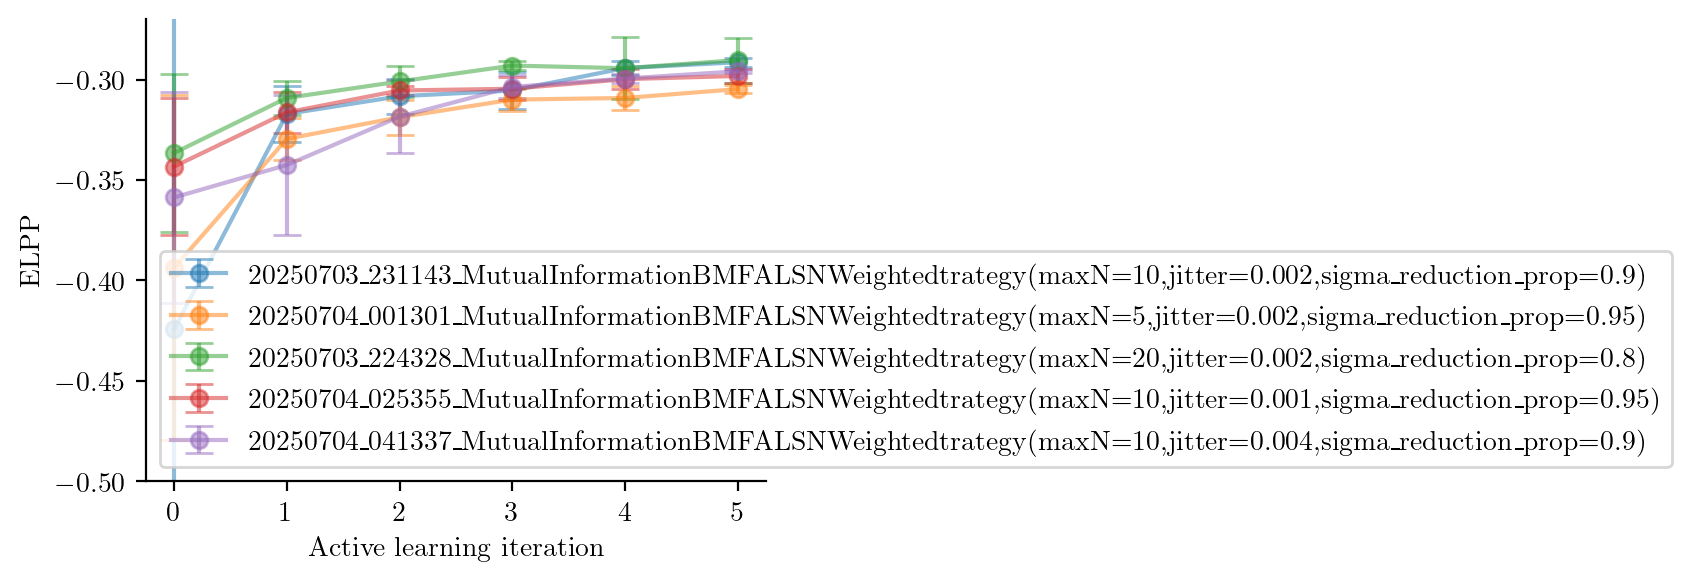